# **1. Importing required libraries and settings**
In the first section, we install and import all the libraries that we will require in the notebook. We also check if some settings are turned on, for smooth operation and to avoid any problems further. 

### **Importing libraries**
Here we have installed the basic python libraries for working with data and visualisation. We also install libraries from tensorflow for working with deep neural networks.

In [ ]:
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import json
import string
import os
import glob
import pickle
import tensorflow as tf
from keras import Input, layers
from keras import optimizers
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization, GlobalAveragePooling2D

This code block tries to avoid the undesirable OOM (Out of memory) problem in which no additional memory can be allocated for use by the program.

In [ ]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,True)

Checking if we are using a High-RAM runtime. Switching to a higher RAM ensures that cells get loaded and executed quickly.


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


# **2. Downloading Coco-2017 dataset from Kaggle**
We have used the Coco-2017 dataset from Facebook. The dataset has more than 100k images and is available to the public. We have connected Kaggle to Google Colab, which lets us download the whole dataset from Kaggle directly to the runtime.

We have also mounted Google Drive which lets us store and load important files. We can download models or pickle files once they are created and keep them in Drive. We can later load these files to save execution time.

In [ ]:
#Installing Kaggle and creating a directory called Kaggle for working
!pip install kaggle
! mkdir ~/.kaggle

print('---------------------------------------------------------------------------------')

#Locating Kaggle Json file in current runtime to help download dataset from Kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

#Downloading Coco-2017 dataset from Kaggle
! kaggle datasets download awsaf49/coco-2017-dataset

print('---------------------------------------------------------------------------------')

# Unzipping dataset and saving in a current runtime directory folder Coco2017 
! unzip coco-2017-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: coco2017/val2017/000000000139.jpg  
  inflating: coco2017/val2017/000000000285.jpg  
  inflating: coco2017/val2017/000000000632.jpg  
  inflating: coco2017/val2017/000000000724.jpg  
  inflating: coco2017/val2017/000000000776.jpg  
  inflating: coco2017/val2017/000000000785.jpg  
  inflating: coco2017/val2017/000000000802.jpg  
  inflating: coco2017/val2017/000000000872.jpg  
  inflating: coco2017/val2017/000000000885.jpg  
  inflating: coco2017/val2017/000000001000.jpg  
  inflating: coco2017/val2017/000000001268.jpg  
  inflating: coco2017/val2017/000000001296.jpg  
  inflating: coco2017/val2017/000000001353.jpg  
  inflating: coco2017/val2017/000000001425.jpg  
  inflating: coco2017/val2017/000000001490.jpg  
  inflating: coco2017/val2017/000000001503.jpg  
  inflating: coco2017/val2017/000000001532.jpg  
  inflating: coco2017/val2017/000000001584.jpg  
  inflating: coco2017/val2017/000000001675.jpg  
  inflating: coco2

# **3. Loading Images from newly created folder.**
We create a path for the folder that contains all the downloaded images of the dataset. The 'val2017' folder consists of 5000 images which we will be using in the notebook.

In [ ]:
#Creating a path for the downloaded dataset from Kaggle
coco_images = '/content/coco2017/val2017'

#Checking length of directory
coco_images_len = len(os.listdir(coco_images))
print('Length of images folder is ', coco_images_len)

#checking number of image files inside the directory to make sure that all images are in the same .jpg format.
coco_images_path = '/content/coco2017/val2017/*.jpg' #Remember to put a / after the path and before the *
coco_images_files = glob.glob(coco_images_path)
print('Number of jpg image files in the folder is ', len(coco_images_files))

Length of images folder is  5000
Number of jpg image files in the folder is  5000


In [ ]:
#Creating a dataframe for image names for understanding how the files are named
coco_images_table = [] 

for file in coco_images_files:
  file_name = file.split('/')[-1]
  coco_images_table.append([file_name])
    
coco_image_df = pd.DataFrame(coco_images_table)
coco_image_df

,0
0,000000269682.jpg
1,000000205542.jpg
2,000000230008.jpg
3,000000474854.jpg
4,000000370270.jpg
...,...
4995,000000202445.jpg
4996,000000028452.jpg
4997,000000542073.jpg
4998,000000013546.jpg


# **4. Loading captions**
In this section we load the annotations/captions of all images. The captions are stored in a json file in the directory mentioned below. Each image has five captions associated with it.

In [ ]:
captions_file = '/content/coco2017/annotations/captions_val2017.json'       #Command for dataset downloaded from Kaggle and unzipped in runtime
with open(captions_file, 'r') as f:
    annotations = json.load(f)

#print(annotations['annotations']) #Prints all annotations
print(annotations['annotations'][0])                                           #Prints first item from annotations

{'image_id': 179765, 'id': 38, 'caption': 'A black Honda motorcycle parked in front of a garage.'}


In [ ]:
import collections

# Grouping all captions together having the same image ID.
grouped_captions_dict = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = (f"{val['caption']}")
  image_path = coco_images + '%012d.jpg' % (val['image_id'])  
  grouped_captions_dict[image_path].append(caption)

In [ ]:
an1 = pd.DataFrame(grouped_captions_dict.items(),columns=['Filename', 'Caption'])
for col in an1.columns:
    an1['Image']= an1['Filename'].str.split('/').str[3].astype(str)

an1 = an1.apply(pd.Series.explode).reset_index(drop=True)
an1 = an1.drop('Filename', axis = 1)
an1 = an1[['Image', 'Caption']]
data= an1.rename(columns={'Image': 'Filename'})
data['Filename'] = data['Filename'].str.replace('val2017', '')
data

,Filename,Caption
0,000000179765.jpg,A black Honda motorcycle parked in front of a ...
1,000000179765.jpg,A Honda motorcycle parked in a grass driveway
2,000000179765.jpg,A black Honda motorcycle with a dark burgundy ...
3,000000179765.jpg,Ma motorcycle parked on the gravel in front of...
4,000000179765.jpg,A motorcycle with its brake extended standing ...
...,...,...
25009,000000537802.jpg,Three teddy bears sit on a fake sled in fake s...
25010,000000537802.jpg,a picture of stuffed animals on a sled in a fa...
25011,000000537802.jpg,Three teddy bears sit in a sled in fake snow.
25012,000000537802.jpg,Three stuffed bears wearing clothes riding on ...


We can see that there are more than 25000 rows in the table which means some images have more than 5 captions. We can find that out below.

In [ ]:
#Checking if each image in the dataset has a unique filename and storing it in a variable
unique_files = np.unique(data.Filename.values)
print("The number of unique file names : {}".format(len(unique_files)))
print("The distribution of the number of captions for each image:")

#Counting how many captions each image has
from collections import Counter 
print("The distribution of the number of captions for each image:")
Counter(Counter(data.Filename.values).values())

The number of unique file names : 5000
The distribution of the number of captions for each image:


Counter({5: 4987, 6: 12, 7: 1})

We can see that there are 12 images that have 6 captions instead of 5, and one image that has 7 captions. We can remove them or keep them if the dataset is large enough. Here we have decided to keep them.

# **5. Checking shape of images and visualising images**
We load a random sample image from the dataset and check what it's dimensions are.

The shape of the image is: (436, 640, 3)


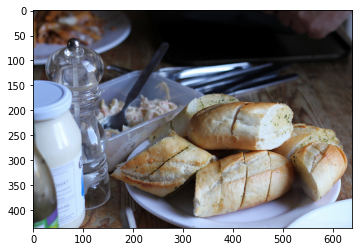

In [ ]:
example_image= plt.imread('/content/coco2017/val2017/000000064084.jpg')
plt.imshow(example_image)
print(f"The shape of the image is: {example_image.shape}")

The input image size required for InceptionV3 is 299*299. Below is an example that shows one image from the dataset along with its five captions 

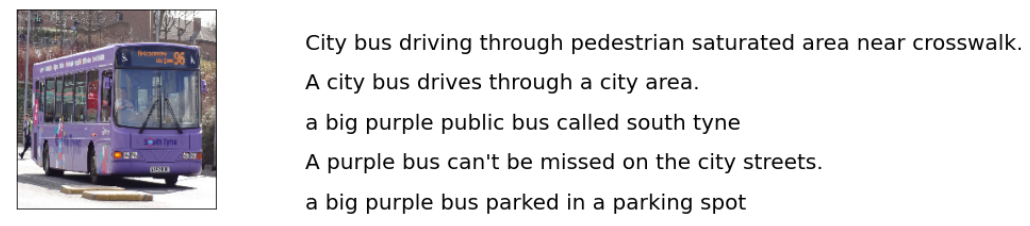

## **6. Loading InceptionV3 for image preprocessing**
Next, we will use InceptionV3 (which is pretrained on the large Imagenet dataset) to extract features from the images. We create features for each image using InceptionV3's pre-trained networks. We will extract features from the last convolutional layer.

First, we will convert the images into InceptionV3's expected format by resizing the image to 299*299 pixels

In [ ]:
from keras.applications.inception_v3 import preprocess_input #Used to preprocess any given image to extract features from that image

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = preprocess_input(img)
    return img, image_path

This is the model that we are going to use 

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model #Instantiate a model to include the necessary layers (input and output)

#Loading the Inception_V3 model
inception_model = InceptionV3(weights="imagenet") #This will return an InceptionV3 network trained on the ImageNet database. 

#We don't need the final predictions layer from the VGG16 architecture as we do not want to classify images. Hence we remove the last layer
inception_model.layers.pop()
inception_model = Model(inputs=inception_model.inputs, outputs=inception_model.layers[-2].output)

for layer in inception_model.layers:
  layer.trainable = False #This freezes the layer so that they are not trained

print(inception_model.summary())

96124928/96112376 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                  

# **7. Feature Extraction**
Now that we have loaded the model, we start to extract features of all images.

In [ ]:
from tqdm.notebook import tqdm
from keras.preprocessing.image import load_img #Used to load an image from a file as a Python Image Library image. 
from keras.preprocessing.image import img_to_array #Used to convert image to numerical array so that model can interpret the array

#We extract features from image and store them in a variable
inception_features = {}

directory = coco_images #This is the main directory which we defined earlier that contains the 5000 images

for img_name in tqdm(os.listdir(directory)):
    image_path = directory + '/' + img_name #Loading the image from directory
    image = load_img(image_path, target_size=(299, 299))
    image = img_to_array(image) #Converting the image pixels into a numpy array
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2])) #Reshaping the data for our InceptionV3 model
    image = preprocess_input(image) #Preprocess the image for InceptionV3. Here we have used the preprocess_input library which we imported from keras.applications.inception_v3
    feature = inception_model.predict(image, verbose=0) #Extracting individual image features
    image_id = img_name.split('.')[0] #Getting image ID's
    inception_features[image_id] = feature #Storing all features in the features dictionary

  0%|          | 0/5000 [00:00<?, ?it/s]

### **Using Pickle to store and load extracted features**

We can directly save the features variable 'features' in a pickle file using the 'dump' command.

We can further use this file in two ways:
1. Load the features back into 'features' variable by loading pickle file from current runtime
2. Download the pickle file after it is created, upload and save it in Google drive. This method is much more efficient as we do not have to extract features every time. After running the feature extraction codeblock once, we do not need to use it again, instead we can load the features from the pickle file saved in Google drive. This way is better while working with large datasets when feature extraction takes a long time.

In [ ]:
# Open a file and use dump()
with open('InceptionV3_features.pkl', 'wb') as file:
      
    # A new file will be created called 'InceptionV3_features.pkl'. Open the file and use dump() to save features to it
    pickle.dump(inception_features, file)

The load() method loads a pickled file and returns a deserialized variable.

In [ ]:
# Creating a path for loading the pickle file 
pickl = 'InceptionV3_features.pkl'

# Open the file in binary mode
with open(pickl, 'rb') as file:
  # Call load method to deserialze
  inception_features = pickle.load(file)

# **8. Mapping captions to images**
Here we map captions to images. The code call below will create a dataframe that shows each image with its five captions placed in separate rows. We have used this dataframe only to display the data in a tabular form. We can see there are 5000 rows in the table.

In [ ]:
nc = pd.DataFrame(grouped_captions_dict.items(),columns=['Filename', 'Caption'])
for col in nc.columns:
    nc['Image']= nc['Filename'].str.split('/').str[3].astype(str)

nc = nc.drop('Filename', axis = 1)
nc = nc[['Image', 'Caption']]
nc= nc.rename(columns={'Image': 'Filename'})

nc['Filename'] = nc['Filename'].str.replace(r'val2017', '')
nc

,Filename,Caption
0,000000179765.jpg,[A black Honda motorcycle parked in front of a...
1,000000190236.jpg,[An office cubicle with four different types o...
2,000000331352.jpg,"[A small closed toilet in a cramped space., A ..."
3,000000517069.jpg,[Two women waiting at a bench next to a street...
4,000000182417.jpg,[A beautiful dessert waiting to be shared by t...
...,...,...
4995,000000018380.jpg,"[a group of people sit around a big table , a ..."
4996,000000142620.jpg,[A man that is sitting down on a bench in fro...
4997,000000541634.jpg,"[A bowl that has food inside of it., a table t..."
4998,000000064084.jpg,"[A batch of bread slices sitting on a plate., ..."


**Grouping all captions together having the same image ID and store them in a map dictionary.**


In [ ]:
image_captions_dict = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = (f"{val['caption']}")
  #image_path = '%012d.jpg' % (val['image_id']) 
  image_path = '%012d' % (val['image_id'])  
  image_captions_dict[image_path].append(caption)

In [ ]:
image_captions_dict

defaultdict(list,
            {'000000179765': ['A black Honda motorcycle parked in front of a garage.',
              'A Honda motorcycle parked in a grass driveway',
              'A black Honda motorcycle with a dark burgundy seat.',
              'Ma motorcycle parked on the gravel in front of a garage',
              'A motorcycle with its brake extended standing outside'],
             '000000190236': ['An office cubicle with four different types of computers.',
              'The home office space seems to be very cluttered.',
              'an office with desk computer and chair and laptop.',
              'Office setting with a lot of computer screens.',
              'A desk and chair in an office cubicle.'],
             '000000331352': ['A small closed toilet in a cramped space.',
              'A tan toilet and sink combination in a small room.',
              'This is an advanced toilet with a sink and control panel.',
              'A close-up picture of a toilet with a 

In [ ]:
#Checking the length
print('Length of the mapping dictionar is ', len(image_captions_dict))

Length of the mapping dictionar is  5000


We can clean the data by removing some small characters which we may not want to show in our final results. This may include special characters or unwanted spaces. Here we define a preocessinging function to do the same.

In [ ]:
def preocessing(image_captions_dict):
    for key, captions in image_captions_dict.items():
        for i in range(len(captions)):
            caption = captions[i] #Taking one caption at a time
            caption = caption.replace('\s+', ' ') #Deleting additional spaces from captions
            #Adding start and end tags to the caption to help us understand when a caption has started and ended.
            caption = '<Startseq> ' + " ".join([word for word in caption.split() if len(word)>1]) + ' <Endseq>'
            captions[i] = caption

In [ ]:
#Checking the sample captions of an image before preprocessing of text
image_captions_dict['000000537802']

['Three teddy bears sit on a fake sled in fake snow.',
 'a picture of stuffed animals on a sled in a fake winter setting',
 'Three teddy bears sit in a sled in fake snow.',
 'Three stuffed bears wearing clothes riding on a sled.',
 'A set of plush toy teddy bears sitting in a sled.']

In [ ]:
#Preprocessing the text
preocessing(image_captions_dict)

In [ ]:
#Checking the sample captions of the same image after preprocessing of text
image_captions_dict['000000537802']

['<Startseq> Three teddy bears sit on fake sled in fake snow. <Endseq>',
 '<Startseq> picture of stuffed animals on sled in fake winter setting <Endseq>',
 '<Startseq> Three teddy bears sit in sled in fake snow. <Endseq>',
 '<Startseq> Three stuffed bears wearing clothes riding on sled. <Endseq>',
 '<Startseq> set of plush toy teddy bears sitting in sled. <Endseq>']

We can see how many captions we have in our dataset and how many unique words are present in all the captions

In [ ]:
#Creating a dictionary for storing all captions
captions_dict = []

#Appending dictionary with all captions
for key in image_captions_dict:
    for caption in image_captions_dict[key]:
        captions_dict.append(caption)

In [ ]:
#Showing length
len(captions_dict)

25014

In [ ]:
captions_dict[:10]

['<Startseq> black Honda motorcycle parked in front of garage. <Endseq>',
 '<Startseq> Honda motorcycle parked in grass driveway <Endseq>',
 '<Startseq> black Honda motorcycle with dark burgundy seat. <Endseq>',
 '<Startseq> Ma motorcycle parked on the gravel in front of garage <Endseq>',
 '<Startseq> motorcycle with its brake extended standing outside <Endseq>',
 '<Startseq> An office cubicle with four different types of computers. <Endseq>',
 '<Startseq> The home office space seems to be very cluttered. <Endseq>',
 '<Startseq> an office with desk computer and chair and laptop. <Endseq>',
 '<Startseq> Office setting with lot of computer screens. <Endseq>',
 '<Startseq> desk and chair in an office cubicle. <Endseq>']

We have to tokenize the text to know how many unique words are present in our vocabulary.

In [ ]:
from keras.preprocessing.text import Tokenizer
#Tokenizing the text
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(captions_dict)
vocab_size = len(word_tokenizer.word_index) +1

print('The number of words present in our vocabulary are ', vocab_size)

The number of words present in our vocabulary are  7266


In [ ]:
#Checking the maximum length of the caption available
max_caption_length = max(len(caption.split()) for caption in captions_dict)
print('The maximum length of a captions is ', max_caption_length)

The maximum length of a captions is  47


# **9. Train-Test Split**
We divide the dataset into a 90:10 ratio, where 90% data will be used to train the model and 10% will be used to test the results

In [ ]:
# Creating a variable image_names using the keys from image_captions_dict
image_names = list(image_captions_dict.keys())

# Splitting the variable into a 90:10 ratio
split = int(len(image_names) * 0.90)

# Defining the training data
training_data = image_names[:split]

# Defining the testing data
testing_data = image_names[split:]

We create a caption generator that will convert the dataset to small batches. When the model will get this data in batches, the model learns in a much smoother way and this prevents the session from crashing.

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Creating the caption generator
def caption_generator(data_keys, image_captions_dict, inception_features, word_tokenizer, max_caption_length, vocab_size, batch_size):

    # Creating lists for different parts of the image_captions_dict variable
    X1 = list() # Will contain keys i.e. image id's
    X2 = list() # Will contain in-sequence of captions
    y = list() # Will contain out-sequence of captions
    n = 0

    # Looping over images
    while 1:
        for key in data_keys:
            n += 1
            captions = image_captions_dict[key]
            # Creating a for loop to process every caption
            for caption in captions:
                # Encoding the sequence
                seq = word_tokenizer.texts_to_sequences([caption])[0]
                # Splitting the sequence into X and y pairs
                for i in range(1, len(seq)):
                    # Splitting the sequence into input and output pairs
                    input_sequence, output_sequence = seq[:i], seq[i]
                    # Padding the input sequence
                    input_sequence = pad_sequences([input_sequence], maxlen=max_caption_length)[0]
                    # Encoding the output sequence
                    output_sequence = to_categorical([output_sequence], num_classes=vocab_size)[0]
                    
                    # Storing the sequences into the lists defined above
                    X1.append(inception_features[key][0])
                    X2.append(input_sequence)
                    y.append(output_sequence)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

# **10. Model creation**
We create a model that will be used for predicting the captions from the images that are passed to it. It consists of an encoder and a decoder.

In the encoder network, the model reads an entire sequence (caption that is given to it), encodes it and generates a representative sentence that describes the image. The decoder network takes this encoded representative sentence and gives an output of words. This process takes place until the end of sequence token.

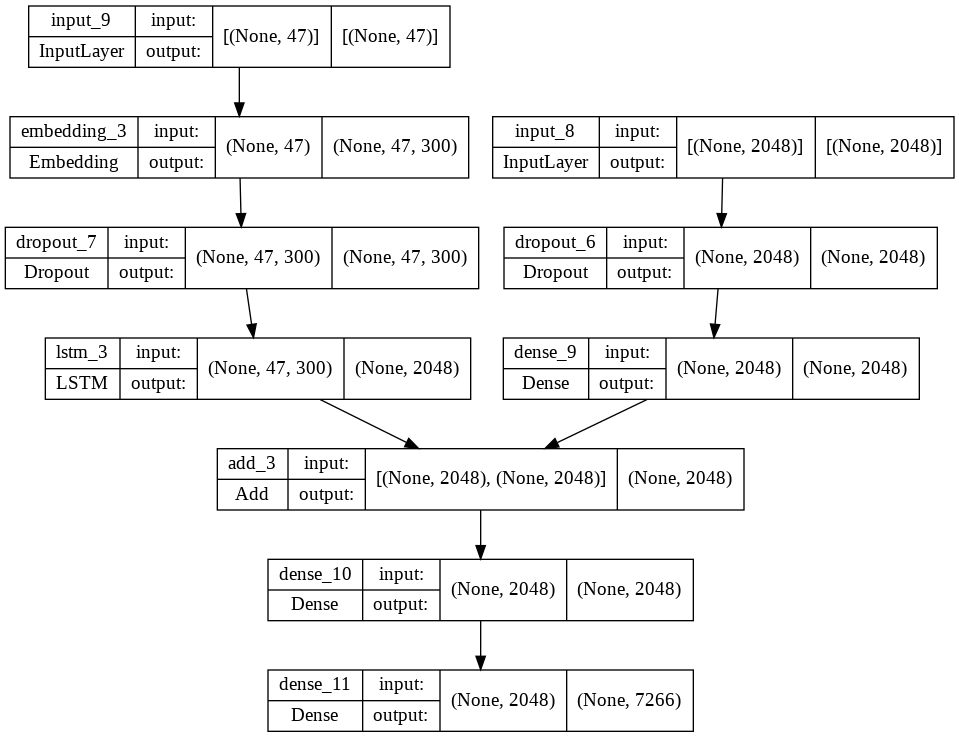

In [ ]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

# Defining the Encoder network
# Image feature layers are below
image_features_input = Input(shape=(2048,))                                                  
fe1 = Dropout(0.4)(image_features_input)
fe2 = Dense(2048, activation='relu')(fe1)

# Sequence feature layers are given below
text_features_input = Input(shape=(max_caption_length,))
se1 = Embedding(vocab_size, 300, mask_zero=True)(text_features_input)
se2 = Dropout(0.4)(se1)
se3 = LSTM(2048)(se2)

# Defining the decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(2048, activation='relu')(decoder1)
decoder_outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Creating a model variable
model = Model(inputs=[image_features_input, text_features_input], outputs=decoder_outputs)

# We use an optimizer called ADAM and set a custom learning rate for it. Lower the learning rate is, slower the convergence is, but higher the chances of reaching global minima
opt = tf.keras.optimizers.Adam(learning_rate = 0.001)

# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer= opt, metrics = ["accuracy"])

# Plotting the model
plot_model(model, show_shapes=True)

In [ ]:
#Printing the summary of the custom model
print(model.summary())

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 47)]         0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 47, 300)      2179800     ['input_9[0][0]']                
                                                                                                  
 dropout_6 (Dropout)            (None, 2048)         0           ['input_8[0][0]']                
                                                                                            

We can pass callbacks to the keras method fit, which we have used later, so that we can hook into various stages of the model training.

### **Checkpoint**
We create a checkpoint variable by importing two important libraries from Tensorflow - EarlyStopping and ModelCheckpoint. These libraries are important because they help us save time and increase efficiency.

In [ ]:
# Callback to save the Keras model or model weights at some frequency. It inherits from the Callbacks class.
from tensorflow.keras.callbacks import ModelCheckpoint

# EarlyStopping is used to stop model training when a monitored metric (in this case accuracy) has stopped improving. It inherits from the Callbacks class.
from tensorflow.keras.callbacks import EarlyStopping

weightspath = 'Inception_weights_Acc{accuracy:.2f}.hdf5'
checkpoint = ModelCheckpoint(weightspath, monitor = 'accuracy', verbose = 0, save_best_only = True, mode = 'max')
earlys = EarlyStopping(monitor = 'accuracy', patience = 10) 
# Here Patience = 10 means that the model will wait till 10 epochs to check if the accuracy is increasing or not. If it does not increase after 10 epochs, it stops.

callbacks_list = [checkpoint, earlys]

# **11. Training the model**
We can load a pre trained model and do some further training on it to increase its training accuracy. 

To save some time, we have already trained the model for 50 epochs, with a batch size of 32 and the learning rate of 0.001 that we defined above. We load this model and train it further for 5 epochs to check how it is being trained. 

In [ ]:
ef = '/content/Inception_weights_Acc0.84.hdf5'
model.load_weights(ef) #Loading weights from the above defined model

In the above cell, we have loaded a model which we have trained previously. The file that we have loaded is in a .h5 file format. An H5 file is a data file saved in the Hierarchical Data Format (HDF) which will contain the multidimensional arrays of our data.

In [ ]:
# Training the model by defining the number of epochs and batch size
epochs = 5
batch_size = 32
steps = len(training_data) // batch_size

for i in range(epochs):

    # Creating the caption generator variable
    inception_generator = caption_generator(training_data, image_captions_dict, inception_features, word_tokenizer, max_caption_length, vocab_size, batch_size)

    # Fitting for one epoch and saving it in a variable called history
    history = model.fit(inception_generator, epochs=1, steps_per_epoch=steps, callbacks = callbacks_list, verbose=1)

140/140 [==============================] - 336s 2s/step - loss: 0.5101 - accuracy: 0.8464


### **Using model.save to store and load trained model**
We can directly save the newly trained model in a .h5 file format.

We can further use this file in two ways:
1. Load the H5 file back into the 'model' variable by loading model file from current runtime
2. Download the H5 file after it is created, upload and save it in Google drive. This method is much more efficient as we do not have to train the model every time. After running the model training codeblock once, we do not need to use it again, instead we can use the H5 file saved in Google drive.

In [ ]:
# Creating an HDF5 file 'New_InceptionV3_model.h5'
model.save('New_InceptionV3_model.h5')  

from keras.models import load_model #Used to save the pre-trained model in a .h5 file format

# Returning a compiled model i.e. loading the model back again.
loaded_model = load_model('New_InceptionV3_model.h5')

# **12. Generating captions for the images**
Now that we have done defining the important parts, we can generate captions for images.

In [ ]:
# Creating a function that will convert an index to a word
def index_to_word_convertor(integer, word_tokenizer):
    for word, index in word_tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# Generating caption for an image

def caption_predictor(model, image, word_tokenizer, max_caption_length):
    in_text = 'startseq' # Adding startseq tag for generation process
    # Iterating over the max length of sequence
    for i in range(max_caption_length):
        sequence = word_tokenizer.texts_to_sequences([in_text])[0] #Encoding input sequence
        sequence = pad_sequences([sequence], max_caption_length) #Padding the sequence
        yhat = model.predict([image, sequence], verbose=0) #Predicting the next word
        yhat = np.argmax(yhat) #Getting the index with high probability
        word = index_to_word_convertor(yhat, word_tokenizer) #Converting index to a word
        if word is None: #Stopping if the word is not found
            break
        in_text += " " + word #Appending word as input for generating next word
        if word == 'endseq': #Stopping if we reach end tag
            break  
    return in_text

### **Validating our predictions with test data**
We can now use our testing data to validate our predictions. We check how our model has performed using the BLEU score measure.

BLEU is short for BiLingual Evaluation Understudy and is a metric used to automatically evaluate machine-translated text. It is a number between zero and one and it measures the similarity of the machine-translated text (in our case the generated aptions) to the reference captions.

In [ ]:
from nltk.translate.bleu_score import corpus_bleu #Used to display BLEU score of images
#Validating with test data
actual_cap_list = list()
predicted_cap_list = list()

for key in tqdm(testing_data):
    #Getting actual caption
    captions = image_captions_dict[key]
    #Predicting the caption for image
    y_pred = caption_predictor(model, inception_features[key], word_tokenizer, max_caption_length) 
    #Splitting into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    #Appending to the list
    actual_cap_list.append(actual_captions)
    predicted_cap_list.append(y_pred)
    
#Calcuating BLEU scores
print('BLEU scores for Inception and LSTM combined model')
print("BLEU-1: %f" % corpus_bleu(actual_cap_list, predicted_cap_list, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual_cap_list, predicted_cap_list, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual_cap_list, predicted_cap_list, weights=(0.33, 0.33, 0.33, 0)))
print("BLEU-4: %f" % corpus_bleu(actual_cap_list, predicted_cap_list, weights=(0.25, 0.25, 0.25, 0.25)))

  0%|          | 0/500 [00:00<?, ?it/s]

BLEU scores for Inception and LSTM combined model
BLEU-1: 0.322581
BLEU-2: 0.174316
BLEU-3: 0.102654
BLEU-4: 0.056391


# **13.Visualising the Results**
We visualise the results by passing random images to tge function defined below. The function will generate captions of the image.

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_new_caption(image_name):
    image_id = image_name.split('.')[0] #Loading the image
    image_path = os.path.join(coco_images, image_name)
    image = Image.open(image_path)
    captions = image_captions_dict[image_id]
    print('---------------------Ground truth caption---------------------')
    for caption in captions:
        print(caption)
    y_pred = caption_predictor(model, inception_features[image_id], word_tokenizer, max_caption_length)  #Predicting the caption
    print('----------------------Generated Caption--------------- -------')
    print(y_pred)
    plt.imshow(image)

Lets check what captions our model has generated for few images.

---------------------Ground truth caption---------------------
<Startseq> black Honda motorcycle parked in front of garage. <Endseq>
<Startseq> Honda motorcycle parked in grass driveway <Endseq>
<Startseq> black Honda motorcycle with dark burgundy seat. <Endseq>
<Startseq> Ma motorcycle parked on the gravel in front of garage <Endseq>
<Startseq> motorcycle with its brake extended standing outside <Endseq>
----------------------Generated Caption--------------- -------
startseq ma motorcycle parked on the gravel in front of garage endseq


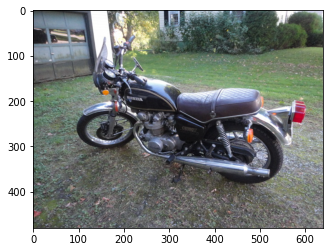

In [ ]:
generate_new_caption("000000179765.jpg")

---------------------Ground truth caption---------------------
<Startseq> group of people sit around big table <Endseq>
<Startseq> family sitting around long table filled with lot of food <Endseq>
<Startseq> lot of people sitting around table full of food. <Endseq>
<Startseq> large family enjoying dinner on large table <Endseq>
<Startseq> Lots of people at long table eating, drinking and smiling <Endseq>
----------------------Generated Caption--------------- -------
startseq four people enjoying meal are posing for their picture endseq


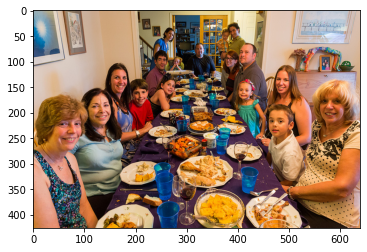

In [ ]:
generate_new_caption("000000018380.jpg")

---------------------Ground truth caption---------------------
<Startseq> Two women waiting at bench next to street. <Endseq>
<Startseq> woman sitting on bench and woman standing waiting for the bus. <Endseq>
<Startseq> woman sitting on bench in the middle of the city <Endseq>
<Startseq> woman sitting on bench and woman standing behind the bench at bus stop <Endseq>
<Startseq> woman and another woman waiting at stop. <Endseq>
----------------------Generated Caption--------------- -------
startseq woman sitting on bench and woman standing waiting for the bus endseq


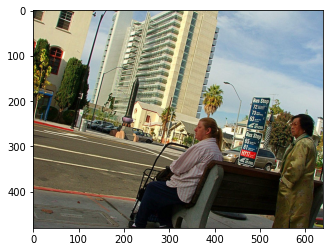

In [ ]:
generate_new_caption("000000517069.jpg")

---------------------Ground truth caption---------------------
<Startseq> red and blue plan on the runway getting ready to get passengers <Endseq>
<Startseq> The airplane is parked on the runway in the airport. <Endseq>
<Startseq> red yellow and blue airplane is sitting on the runway. <Endseq>
<Startseq> Southwest Airlines jet pulled up to the terminal for loading. <Endseq>
<Startseq> blue and red plane on runway <Endseq>
----------------------Generated Caption--------------- -------
startseq the plane is parked at the runway endseq


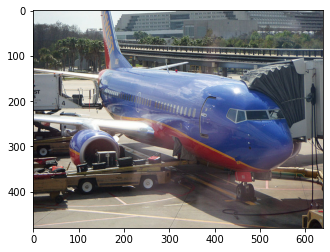

In [ ]:
generate_new_caption("000000579158.jpg")

---------------------Ground truth caption---------------------
<Startseq> The person walking the dog has dressed it in torn shirt. <Endseq>
<Startseq> dog that is lying down on the sidewalk. <Endseq>
<Startseq> small dog wearing shirt and sniffing something on the ground <Endseq>
<Startseq> small long haired dog wearing shirt and bandana, on leash. <Endseq>
<Startseq> dog wearing scarf and shirt on leash <Endseq>
----------------------Generated Caption--------------- -------
startseq young girl with plastic goggles on in front of broken tower endseq


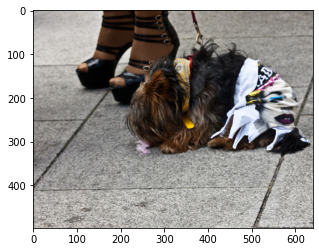

In [ ]:
generate_new_caption("000000579321.jpg")

---------------------Ground truth caption---------------------
<Startseq> man surfing in the ocean with sail boat behind him. <Endseq>
<Startseq> person riding wave on top of surfboard. <Endseq>
<Startseq> man on surfboard is riding large wave. <Endseq>
<Startseq> surfer is riding the waves as sailboat sails in the background. <Endseq>
<Startseq> man on surfboard riding wave <Endseq>
----------------------Generated Caption--------------- -------
startseq man in wet suit riding surfboard on surf board endseq


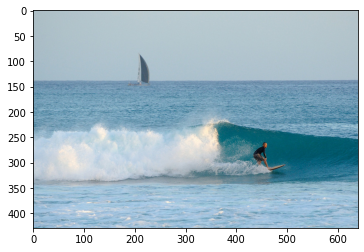

In [ ]:
generate_new_caption("000000579635.jpg")

---------------------Ground truth caption---------------------
<Startseq> close up of the stop sign and to street signs. <Endseq>
<Startseq> close up of street sign with sky background <Endseq>
<Startseq> The stop sign is at four way intersection. <Endseq>
<Startseq> stop sign located at the intersection of East Village and Woodfield Rd. <Endseq>
<Startseq> red stop sign with two green street signs on top of it. <Endseq>
----------------------Generated Caption--------------- -------
startseq sign with trailer that has gentrifying bicycles on it endseq


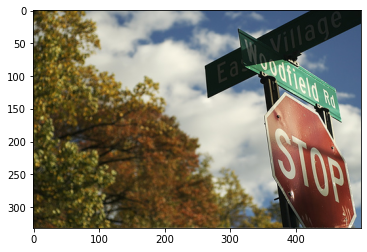

In [ ]:
generate_new_caption("000000579893.jpg")

---------------------Ground truth caption---------------------
<Startseq> small loaded pizza on yellow plate <Endseq>
<Startseq> pizza topped with an assortment of vegetables on wooden table. <Endseq>
<Startseq> delicious looking pizza with variety of vegetable toppings stands out on yellow plate. <Endseq>
<Startseq> fresh pizza with basil, mozzarella cheese and tomatoes. <Endseq>
<Startseq> an image of small pizza on plate <Endseq>
----------------------Generated Caption--------------- -------
startseq pizza with ingredients that include tomatoes and meatballs endseq


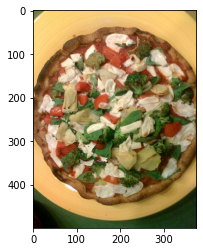

In [ ]:
generate_new_caption("000000579900.jpg")

---------------------Ground truth caption---------------------
<Startseq> person riding motorcycle down street. <Endseq>
<Startseq> and man with skateboard on motorcycle in traffic <Endseq>
<Startseq> man on motor bike riding in the high way <Endseq>
<Startseq> motorcyclist is driving down the road next to the road barrier. <Endseq>
<Startseq> person on motorcycle driving on the break down lane. <Endseq>
----------------------Generated Caption--------------- -------
startseq person riding motorcycle down the side of road endseq


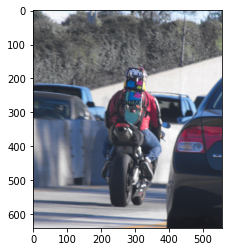

In [ ]:
generate_new_caption("000000579902.jpg")

# **14. Conclusion**
By reading the captions below, we may conclude the following:
1.   The model predicts most objects and animals correctly
2.   The model predicts human faces correctly with near accurate predictions of peoples age.
3. The model predicts positions of objects with minimal error.

